# Exercícios de Redução de Dimensionalidade

## Introdução

Utilizaremos os dados de um [distribuidor por atacado Português](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers) para agrupamento. Essa base de dados tem o nome de `Wholesale_Customers_Data`.

Essa base contêm os seguintes atributos:

* Fresh: annual spending (m.u.) on fresh products
* Milk: annual spending (m.u.) on milk products
* Grocery: annual spending (m.u.) on grocery products
* Frozen: annual spending (m.u.) on frozen products
* Detergents_Paper: annual spending (m.u.) on detergents and paper products
* Delicatessen: annual spending (m.u.) on delicatessen products
* Channel: customer channel (1: hotel/restaurant/cafe or 2: retail)
* Region: customer region (1: Lisbon, 2: Porto, 3: Other)

Nessa base, os valores de gastos são dados em uma unidade arbitrária (m.u. = monetary unit, unidade monetária).

## Exercício 1

* Importe os dados e verifique os seus tipos.
* Remova as colunas channel e region.
* Converta o restante para floats se necessário.
* Copie a variável original de data (usando o método `copy`) para preservá-la.

In [1]:
import pandas as pd
import numpy as np

filepath = 'data/Wholesale_Customers_Data.csv'
data = pd.read_csv(filepath, sep=',')

In [2]:
data.shape

(440, 8)

In [3]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
data = data.drop(["Channel", "Region"], axis=1)

In [5]:
# tipos das variáveis
data.dtypes

Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [6]:
# Converte para floats
for col in data.columns:
    data[col] = data[col].astype(np.float)

Faça uma cópia do original.

In [7]:
data_orig = data.copy()

## Exercício 2

Vamos repetir o procedimento de transformação e escala da atividade anterior (Exercício 2):

* Examine a correlação e viés.
* Faça a transformação e escalonamento necessários.
* Visualize as correlações par a par.

In [10]:
# matriz de correlação
corr_mat = data.corr()

# Sete a diagonal com 0.0
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,0.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,0.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,0.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,0.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,0.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,0.000000


Retorne o id de máxima correlação:

In [13]:
corr_mat.abs().max()

Fresh               0.345881
Milk                0.728335
Grocery             0.924641
Frozen              0.390947
Detergents_Paper    0.924641
Delicassen          0.406368
dtype: float64

Examine os atributos com viés e aplique log1p:

In [16]:
log_columns = data.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

Delicassen          11.151586
Frozen               5.907986
Milk                 4.053755
Detergents_Paper     3.631851
Grocery              3.587429
Fresh                2.561323
dtype: float64

In [17]:
# The log transformations
for col in log_columns.index:
    data[col] = np.log1p(data[col])

Vamos usar o `MinMaxScaler` para fazer o escalonamento.

In [20]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

for col in data.columns:
    data[col] = mms.fit_transform(data[col].reshape(-1,1)).squeeze() # squeeze transforma em vetor

C:\IntelPython3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Vamos plotar as relações.

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

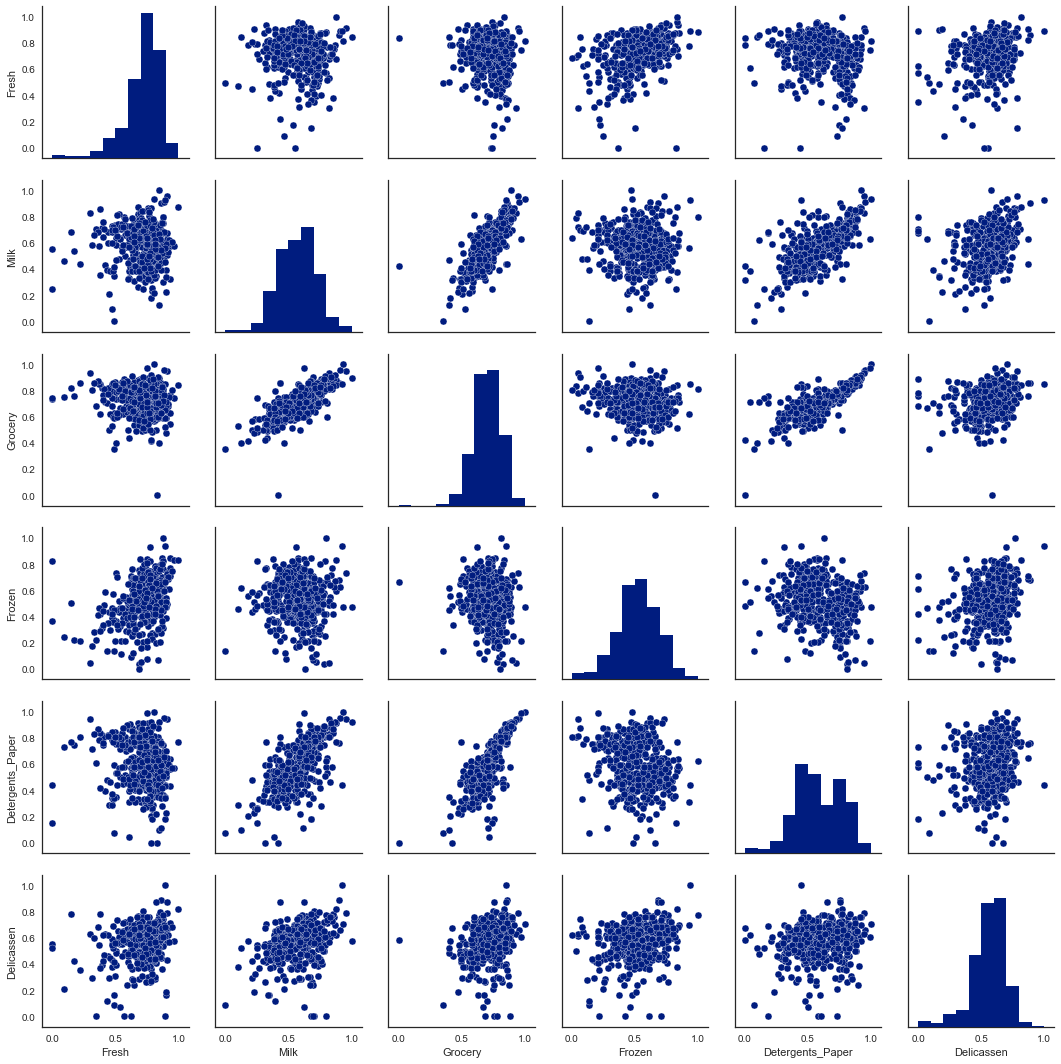

In [22]:
sns.set_context('notebook')
sns.set_palette('dark')
sns.set_style('white')

sns.pairplot(data);

## Exercício 3

* Usando a função [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) do Scikit-Learn, recrie o procedimento acima de pré-processamento (transformação e escala) usando pipeline. Para utilizar uma função de transformação externa (log1p do Numpy) você precisará da classe chamada [`FunctionTransformer`](http://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers).
* Use o pipeline para transformar a cópia dos dados originais.
* Compare com o resultado do exercício anterior para verificar se funcionou.

In [24]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# Crie a transformação log do Numpy para ser utilizada no pipeline
log_transformer = FunctionTransformer(np.log1p)

# O pipeline
estimators = [('log1p', log_transformer), ('minmaxscale', MinMaxScaler())]
pipeline = Pipeline(estimators)

# Converte a cópia dos dados originais
data_pipe = pipeline.fit_transform(data_orig)

Os resultados são idênticos. Note que podemos acrescentar qualquer modelo dentro do pipeline, como algoritmos de classificação e regressão.

In [25]:
np.allclose(data_pipe, data)

True

## Exercício 4

* Aplique o PCA com `n_components` variando entre 1 e 5. 
* Armazene a quantidade de variância explicada (explained_variance_ratio_.sum()) para cada número de dimensões.
* Vamos estimar a importância dos atributos gerados com np.abs(components_).sum(axis=0)/ soma de todos.
* Plote os valores acima.

In [26]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 6):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(data_pipe)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': data.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,"PCA(copy=True, iterated_power='auto', n_compon...",0.448011
2,"PCA(copy=True, iterated_power='auto', n_compon...",0.72099
3,"PCA(copy=True, iterated_power='auto', n_compon...",0.827534
4,"PCA(copy=True, iterated_power='auto', n_compon...",0.923045
5,"PCA(copy=True, iterated_power='auto', n_compon...",0.979574


Vamos criar uma tabela para verificar os resultados:

In [27]:
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

features_df

features,Delicassen,Detergents_Paper,Fresh,Frozen,Grocery,Milk
n,,,,,,
1,0.071668,0.335487,0.060620,0.095979,0.190236,0.246010
2,0.151237,0.177519,0.158168,0.222172,0.112032,0.178872
3,0.165518,0.145815,0.211434,0.268363,0.084903,0.123967
4,0.224259,0.149981,0.239527,0.214275,0.070971,0.100987
5,0.211840,0.182447,0.196382,0.178104,0.067338,0.163888


E vamos plotar os resultados:

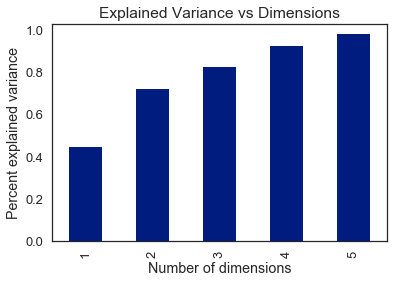

In [28]:
sns.set_context('talk')

ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

E da importância dos atributos:

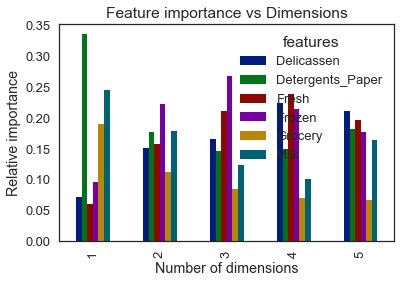

In [29]:
ax = features_df.plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');

## Exercício 5

Vamos verificar como a acurácia de nosso modelo pode mudar se incluírmos um `PCA` no nosso pipeline de processamento. Vamos criar um pipeline com os seguintes passos:
<ol>
  <li>Escalonar</li>
  <li>`PCA(n_components=n)`</li>
  <li>`LogisticRegression`</li>
</ol>

* Para isso utilizaremos a base de dados Human Activity.
* Escreva uma função que pega um valor  `n`  e constrói o pipeline acima, faça a predição da coluna  "Activity" em um StratifiedShuffleSplit de 5 pastas (fold), retorne a acurácia média da base de teste.
* Chame a função acima para vários valores de n.
* Plote a acurácia média pela dimensão.

In [30]:
filepath = 'data/Human_Activity_Recognition_Using_Smartphones_Data.csv'
data2 = pd.read_csv(filepath, sep=',')

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X = data2.drop('Activity', axis=1)
y = data2.Activity
sss = StratifiedShuffleSplit(n_splits=5, random_state=42)

def get_avg_score(n):
    pipe = [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('estimator', LogisticRegression())
    ]
    pipe = Pipeline(pipe)
    scores = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, pipe.predict(X_test)))
    return np.mean(scores)


ns = [10, 20, 50, 100, 150, 200, 300, 400]
score_list = [get_avg_score(n) for n in ns]

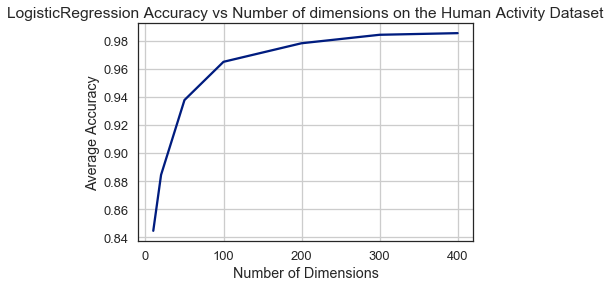

In [34]:
sns.set_context('talk')

ax = plt.axes()
ax.plot(ns, score_list)
ax.set(xlabel='Number of Dimensions',
       ylabel='Average Accuracy',
       title='LogisticRegression Accuracy vs Number of dimensions on the Human Activity Dataset')
ax.grid(True)